In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/SFBay.csv", sep=";")

In [3]:
data.head()

,TimeStamp,Station.Number,Distance.from.36,Depth,Discrete.Chlorophyll,Chlorophyll.a.a.PHA,Fluorescence,Calculated.Chlorophyll,Discrete.Oxygen,Oxygen.Electrode.Output,...,Measured.Extinction.Coefficient,Calculated.Extinction.Coefficient,Salinity,Temperature,Sigma.t,Nitrite,Nitrate...Nitrite,Ammonium,Phosphate,Silicate
0,1969-04-10 16:15:00,4.0,119.90,0.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.3,13.1,NaN,NaN,NaN,NaN,NaN,NaN
1,1969-04-10 16:16:00,4.0,119.90,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.3,13.1,NaN,0.7,NaN,NaN,1.6,236.0
2,1969-04-10 16:17:00,4.0,119.90,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.3,13.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1969-04-10 16:18:00,4.0,119.90,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.3,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1969-04-10 16:30:00,5.0,115.63,0.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.3,14.1,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare data

In [4]:
# drop unwanted columns
data = data[["TimeStamp","Station.Number","Depth","Temperature","Salinity","Oxygen.Electrode.Output","Oxygen.Saturation.percent"]]

In [5]:
# drop time from datetime
data.TimeStamp = data.TimeStamp.str.split(" ").str[0]

# drop data before 01.01.2000
data = data.query("TimeStamp >= '2000-01-01'").sort_values(by="TimeStamp")

# drop day from date
data.TimeStamp = data.TimeStamp.map(lambda x: x[:-3])

In [6]:
# add Area indicator
conditions = [
    (data["Station.Number"]>=3) & (data["Station.Number"]<=8),   # Suisun Bay
    (data["Station.Number"]>=10) & (data["Station.Number"]<=15), # San Pablo Bay
    (data["Station.Number"]>=21) & (data["Station.Number"]<=36)  # South Bay
]
values = ["Suisun Bay", "San Pablo Bay", "South Bay"]
data["Area"] = np.select(conditions, values)

# drop stations not in one of the bays
data = data.query("Area != '0'")

## What to do with depth

<Figure size 432x288 with 0 Axes>

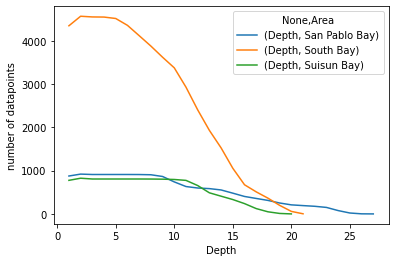

In [7]:
# Check values for different depths (aggregated by area)
depths = pd.DataFrame(data.groupby("Area").Depth.value_counts())

plt.figure()
depths.unstack(level=0).plot(kind='line', subplots=False)
plt.ylabel("number of datapoints")
plt.show()

<Figure size 432x288 with 0 Axes>

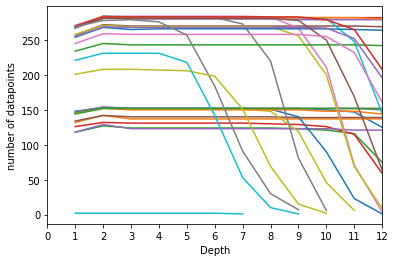

In [8]:
# Check values for different depths (for each station)
depths = pd.DataFrame(data.groupby("Station.Number").Depth.value_counts())

plt.figure()
depths.unstack(level=0).plot(kind='line', subplots=False, xlim=[0,12], xticks=np.arange(0, 13, step=1), legend=None)
plt.ylabel("number of datapoints")
plt.show()

All areas have plenty of data for the shallower depths. Looking at each station individually, all but one have at least 100 datapoints for each depth from 1-6. 

It also becomes apparent, that the high number of datapoints for South Bay comes not from an increase in data collected but instead from the large number of stations within the bay. 

Conclusion: we will use (and aggregate) the values of depths 1-6 for each area and month.

In [9]:
# drop depths deeper than 6
data = data.query("Depth <= 6")

## Aggregate by month and area

In [10]:
# drop station number and depth before aggregating
data = data.drop(["Station.Number", "Depth"], axis=1)

# aggregate by area and month (mean)
data = data.groupby(["Area", "TimeStamp"], as_index=False).median()

## Any remaining NaNs?

In [11]:
data = data.sort_values(by=["TimeStamp","Area"])

In [12]:
data[data["Temperature"].isna() | data["Salinity"].isna() | data["Oxygen.Electrode.Output"].isna() |
    data["Oxygen.Saturation.percent"].isna()]

,Area,TimeStamp,Temperature,Salinity,Oxygen.Electrode.Output,Oxygen.Saturation.percent
34,San Pablo Bay,2003-03,14.190,20.625,8.80,NaN
352,Suisun Bay,2003-03,14.390,2.915,9.80,NaN
371,Suisun Bay,2004-11,NaN,NaN,NaN,NaN
102,San Pablo Bay,2009-08,18.960,26.505,NaN,NaN
420,Suisun Bay,2009-08,19.785,8.435,NaN,NaN
117,San Pablo Bay,2010-12,11.720,23.810,8.35,NaN
279,South Bay,2010-12,12.540,28.725,7.75,NaN
435,Suisun Bay,2010-12,11.685,2.930,9.30,NaN
128,San Pablo Bay,2011-12,10.780,26.120,NaN,NaN
291,South Bay,2011-12,11.090,28.120,NaN,NaN


1) Suisun Bay at 2004-11 has no data

2) All bays sometimes have no Oxygen data (14 / 471 rows) but still have data for Temp & Sal

3) There are no sequential months without data for any area

Conclusion: do standard linear interpolation, but for each area separately and then recombine the data set.

## Do interpolation per area separately

In [13]:
data = pd.concat(
    [data[data.Area == "San Pablo Bay"].interpolate(), 
     data[data.Area == "Suisun Bay"].interpolate(),
     data[data.Area == "South Bay"].interpolate()]
).sort_values(by=["TimeStamp","Area"]).reset_index(drop=True)

## Still any NaNs?

In [14]:
data.isna().any()

Area                         False
TimeStamp                    False
Temperature                  False
Salinity                     False
Oxygen.Electrode.Output      False
Oxygen.Saturation.percent    False
dtype: bool

All good now

# Finished data

In [15]:
data.head(10)

,Area,TimeStamp,Temperature,Salinity,Oxygen.Electrode.Output,Oxygen.Saturation.percent
0,San Pablo Bay,2000-01,10.390,21.305,9.20,88.0
1,South Bay,2000-01,11.010,29.255,8.30,87.0
2,Suisun Bay,2000-01,9.930,6.095,10.40,89.0
3,San Pablo Bay,2000-02,11.740,14.360,10.05,89.0
4,South Bay,2000-02,12.320,21.100,9.60,91.0
5,Suisun Bay,2000-02,11.105,0.130,10.70,85.0
6,San Pablo Bay,2000-03,11.545,2.560,11.00,84.5
7,South Bay,2000-03,13.495,15.895,10.10,93.0
8,Suisun Bay,2000-03,11.435,0.080,11.10,83.0
9,San Pablo Bay,2000-04,14.130,15.610,8.80,94.0


In [16]:
data.to_csv("data/SFBay_processed.csv", index=False)